# **Project: Solar Cycle**

**Course:** Optimisation and High performance Computing (OHPC-HS25-AD23)  
**Team Members:** Cieplinski Nicole, Plos Penelope, Yeji Huber
**Date:** 16.01.2026

In [1]:
import numpy as np
# Replace numdifftools with JAX:
# import numdifftools as nd
# ---------------------------------
# N.B.:
# Required: conda install -c conda-forge jax jaxlib
# ---------------------------------
import jax.numpy as jnp
from jax import grad

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

## Simulated Annealing (SA) function

### SA function for hyper-parameter tuning

In [2]:
def simulated_annealing_tuning(x0, T0, sigma, f, n_iter = 2e5, thinning = 1):

    x = x0.copy()           # initial x
    T = T0                  # initial temperature
    n_params = x0.shape[0]  # number of parameters to optimized

    # Means and covariance matrix for the jump distribution -> multivariate normal with mean 0 and standard deviation sigma 
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Calculate size of the output array after thinning
    # (thinning -> save states at regular intervals instead of every iteration) 
    # Thinning is by defaut 1, and size_out = n_iter
    size_out = int((n_iter + thinning -1)//thinning)    # equivalent to ceiling (n_iter/thinning)
    v = np.zeros((size_out, n_params))
    # Store the initial parameter array
    v[0,:] = x

    iter_counter = 0
    iter_counter_thin = 0
    print("Initial loss:", f(x))
    #start main loop
    while iter_counter < n_iter:
        iter_counter += 1;
        x_old = x;
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        #Metropolis accept/reject step 
        if np.exp(-np.clip(DeltaE, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        
        # Update temperature according to schedule
        T = T0 * (1 - iter_counter/n_iter)
        # Keep track of accepted state
        if iter_counter%1 == 0:
            print("Iteration", iter_counter, " - Temperature:", T, "Loss", f(x))
        if iter_counter%thinning == 0:
            v[iter_counter_thin,:] = x
            iter_counter_thin += 1
    
    return v
    

### SA function for final optimization

In [3]:
def simulated_annealing_optim(x0, T0, sigma, f, n_iter = 2.5e5, burn_in = 2e5):

    x = x0.copy()           # initial x
    T = T0                  # initial temperature
    n_params = x0.shape[0]  # number of parameters to optimized
    
    # means and covariance matrix for the jump distribution -> multivariate normal
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Size of the output array after burn_in
    size_out = int(n_iter - burn_in)
    v = np.zeros((size_out, n_params))
    
    iter_counter = 0
    print("Initial loss:", f(x))
    # Start main loop
    while iter_counter < n_iter:
        iter_counter += 1;
        x_old = x;
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE/T, -100,100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        # Update temperature according to schedule
        T = T0*(1-iter_counter/n_iter)
        # keep track of the algorithm state
        if iter_counter%10 == 0:
            print("Iteration ", iter_counter, " - Temperature:", T, " - Loss:", f(x))
        if iter_counter > burn_in:
            v[iter_counter-int(burn_in)-1, :] = x

    return v 

## Load data

In [4]:
data = np.loadtxt('data_Team9.csv', delimiter=',', skiprows=1) 

In [5]:
data.shape

(39220, 2)

In [6]:
data

array([[1878.15199877,   13.65877439],
       [1878.15477652,   13.22461169],
       [1878.15755428,   14.05492822],
       ...,
       [1987.08717135,    8.53057405],
       [1987.08994911,    3.49094437],
       [1987.09272686,    0.        ]])

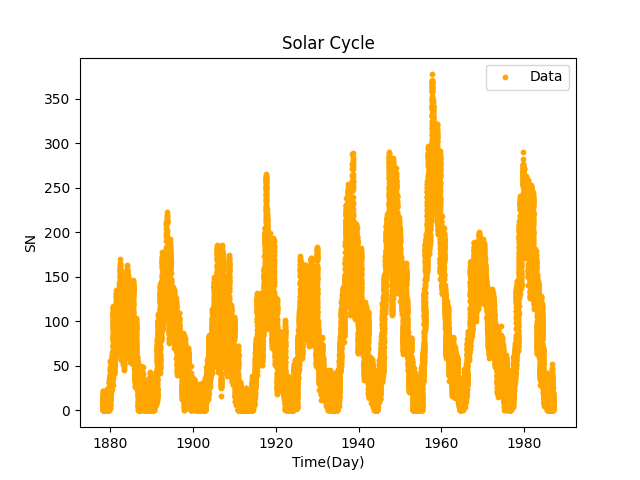

In [7]:
#Plot data for visualization
plt.figure()
plt.scatter(data[:,0], data[:,1], color="Orange", s=10, label= "Data")
plt.xlabel("Time(Day)")
plt.ylabel("SN")
plt.title("Solar Cycle")
plt.legend()
plt.show()

In [8]:
time_points = data[:, 0]
n_data = time_points.shape[0]
data_points = data[:, 1]

print(time_points)
print(n_data)
print(data_points)

[1878.15199877 1878.15477652 1878.15755428 ... 1987.08717135 1987.08994911
 1987.09272686]
39220
[13.65877439 13.22461169 14.05492822 ...  8.53057405  3.49094437
  0.        ]


## Model and Loss Function

### Model

In [ ]:
# parameters 
# Phase 1: T01, Ts1, Td1
# Phase 2: T02, Ts2, Td2 
#...
# Phase 10: T010, Ts10, Td10 
# x0 = np.array([Ts1, Td1, Ts2, Td2, ...])
# here we use initial conditions given in the final project intro 

x0 = np.array([0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5])

In [10]:
# The different parameters can be extracted as follows:
Ts = x0[::2]
Td = x0[1::2]

print(Ts)
print(Td)

# Number of phases
num_phases = len(Ts)
num_phases

[0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]


10

In [ ]:
# make TO array
T0array = ()
# Create list of time intervals for each phase
intervals = [(float(T0array[ix]),float(T0array[ix+1])) for ix in range(num_phases)]

print(intervals)

[(1878.1519987692307, 1889.0460715784614), (1889.0460715784614, 1899.9401443876923), (1899.9401443876923, 1910.834217196923), (1910.834217196923, 1921.7282900061539), (1921.7282900061539, 1932.6223628153846), (1932.6223628153846, 1943.5164356246153), (1943.5164356246153, 1954.4105084338462), (1954.4105084338462, 1965.3045812430769), (1965.3045812430769, 1976.1986540523078), (1976.1986540523078, 1987.0927268615385)]


In [18]:
# We will use a loop to process all phases
for ix, (a, b) in enumerate(intervals):
    print("Processing phase", ix+1, "with interval (", a, ",", b, ")")

Processing phase 1 with interval ( 1878.1519987692307 , 1889.0460715784614 )
Processing phase 2 with interval ( 1889.0460715784614 , 1899.9401443876923 )
Processing phase 3 with interval ( 1899.9401443876923 , 1910.834217196923 )
Processing phase 4 with interval ( 1910.834217196923 , 1921.7282900061539 )
Processing phase 5 with interval ( 1921.7282900061539 , 1932.6223628153846 )
Processing phase 6 with interval ( 1932.6223628153846 , 1943.5164356246153 )
Processing phase 7 with interval ( 1943.5164356246153 , 1954.4105084338462 )
Processing phase 8 with interval ( 1954.4105084338462 , 1965.3045812430769 )
Processing phase 9 with interval ( 1965.3045812430769 , 1976.1986540523078 )
Processing phase 10 with interval ( 1976.1986540523078 , 1987.0927268615385 )


In [19]:
# Model for multiple phases:
def model(t, x):
    Ts = x[::2]
    Td = x[1::2]
    num_phases = len(T0array)
    intervals = [(T0array[ix],T0array[ix+1]) for ix in range(num_phases-1)]
    #Ensure t is treated as an array for consistency
    t = np.atleast_1d(t)
    model_output = np.zeros_like(t)
    for ix, (a,b) in enumerate(intervals):
        # Create mask for current phase
        mask = (a <= t) & (t < b)
        # Apply model for current phase
        model_output[mask] = ((t[mask] - T0array[ix])/Ts[ix])**2 * np.exp(-((t[mask] - T0array[ix])/Td[ix])**2)
    if model_output.size == 1:
        return model_output.item()
    else:
        return model_output


### Loss function

In [20]:
# Loss function
def mse(x):
    return np.mean(np.square(data_points - model(time_points, x)))

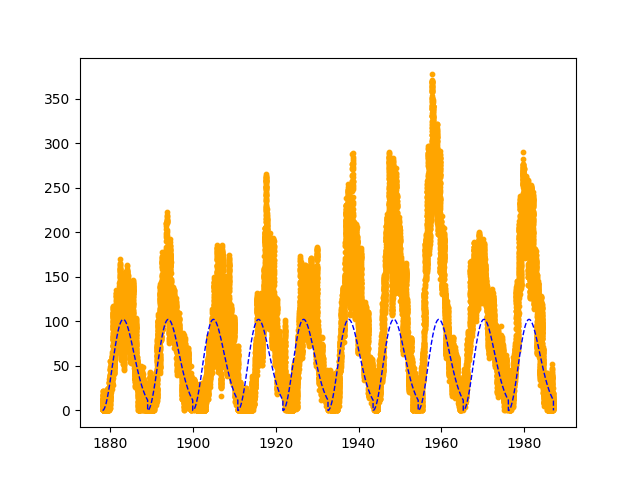

np.float64(3456.4013309558472)

In [21]:
# Visualisation
plt.figure()
plt.scatter(time_points, data_points, color='orange', s=10)
plt.plot(time_points, model(time_points, x0), color='blue', linestyle='--', linewidth=1)
plt.show(block=False)

# Initial mse:
mse(x0)

## Hyper-parameters tuning

### Test to find the sigma range

Initial loss: 3456.4013309558472
Iteration 1  - Temperature: 0.9999 Loss 3456.4013309558472
Iteration 2  - Temperature: 0.9998 Loss 3456.4013309558472
Iteration 3  - Temperature: 0.9997 Loss 3456.4013309558472
Iteration 4  - Temperature: 0.9996 Loss 3456.4013309558472
Iteration 5  - Temperature: 0.9995 Loss 3456.4013309558472
Iteration 6  - Temperature: 0.9994 Loss 3456.4013309558472
Iteration 7  - Temperature: 0.9993 Loss 3456.4013309558472
Iteration 8  - Temperature: 0.9992 Loss 3456.4013309558472
Iteration 9  - Temperature: 0.9991 Loss 3456.4013309558472
Iteration 10  - Temperature: 0.999 Loss 3456.4013309558472
Iteration 11  - Temperature: 0.9989 Loss 3456.4013309558472
Iteration 12  - Temperature: 0.9988 Loss 3456.4013309558472
Iteration 13  - Temperature: 0.9987 Loss 3456.4013309558472
Iteration 14  - Temperature: 0.9986 Loss 3456.4013309558472
Iteration 15  - Temperature: 0.9985 Loss 3456.4013309558472
Iteration 16  - Temperature: 0.9984 Loss 3456.4013309558472
Iteration 17  - T

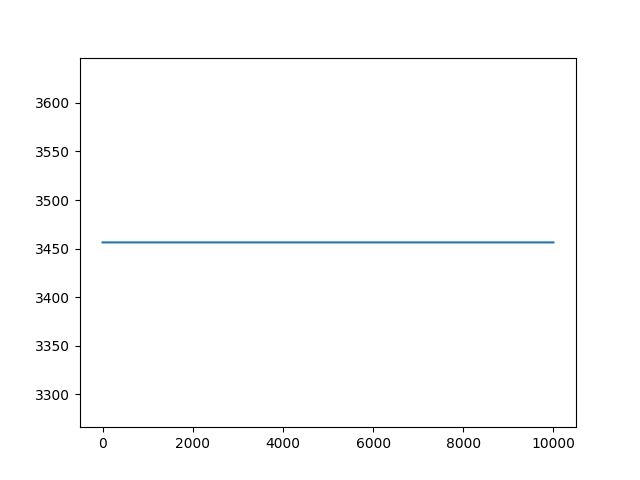

np.float64(3456.4013309558472)

In [22]:
T0 = 1
sigma = 1
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

-> Sigma is too large

Initial loss: 3456.4013309558472
Iteration 1  - Temperature: 0.9999 Loss 3456.4013309558472
Iteration 2  - Temperature: 0.9998 Loss 3456.4013309558472
Iteration 3  - Temperature: 0.9997 Loss 3456.4013309558472
Iteration 4  - Temperature: 0.9996 Loss 3456.4013309558472
Iteration 5  - Temperature: 0.9995 Loss 3456.4013309558472
Iteration 6  - Temperature: 0.9994 Loss 3456.4013309558472
Iteration 7  - Temperature: 0.9993 Loss 3456.4013309558472
Iteration 8  - Temperature: 0.9992 Loss 3456.4013309558472
Iteration 9  - Temperature: 0.9991 Loss 3456.4013309558472
Iteration 10  - Temperature: 0.999 Loss 3456.4013309558472
Iteration 11  - Temperature: 0.9989 Loss 3456.4013309558472
Iteration 12  - Temperature: 0.9988 Loss 3456.4013309558472
Iteration 13  - Temperature: 0.9987 Loss 3456.4013309558472
Iteration 14  - Temperature: 0.9986 Loss 3456.4013309558472
Iteration 15  - Temperature: 0.9985 Loss 3456.4013309558472
Iteration 16  - Temperature: 0.9984 Loss 3456.4013309558472
Iteration 17  - T

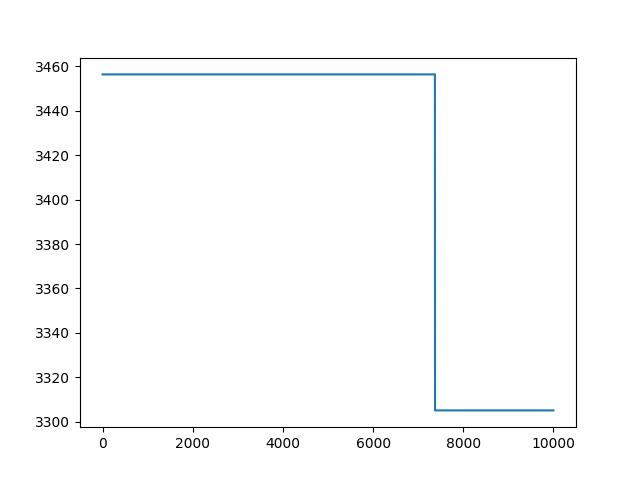

np.float64(3305.052839939574)

In [23]:
T0 = 1
sigma = 0.1
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

-> Sigma is too large

Initial loss: 3456.4013309558472
Iteration 1  - Temperature: 0.9999 Loss 3456.4013309558472
Iteration 2  - Temperature: 0.9998 Loss 3456.4013309558472
Iteration 3  - Temperature: 0.9997 Loss 3456.4013309558472
Iteration 4  - Temperature: 0.9996 Loss 3456.4013309558472
Iteration 5  - Temperature: 0.9995 Loss 3456.4013309558472
Iteration 6  - Temperature: 0.9994 Loss 3456.4013309558472
Iteration 7  - Temperature: 0.9993 Loss 3456.4013309558472
Iteration 8  - Temperature: 0.9992 Loss 3456.4013309558472
Iteration 9  - Temperature: 0.9991 Loss 3456.4013309558472
Iteration 10  - Temperature: 0.999 Loss 3456.4013309558472
Iteration 11  - Temperature: 0.9989 Loss 3456.4013309558472
Iteration 12  - Temperature: 0.9988 Loss 3456.4013309558472
Iteration 13  - Temperature: 0.9987 Loss 3456.4013309558472
Iteration 14  - Temperature: 0.9986 Loss 3456.4013309558472
Iteration 15  - Temperature: 0.9985 Loss 3456.4013309558472
Iteration 16  - Temperature: 0.9984 Loss 3456.4013309558472
Iteration 17  - T

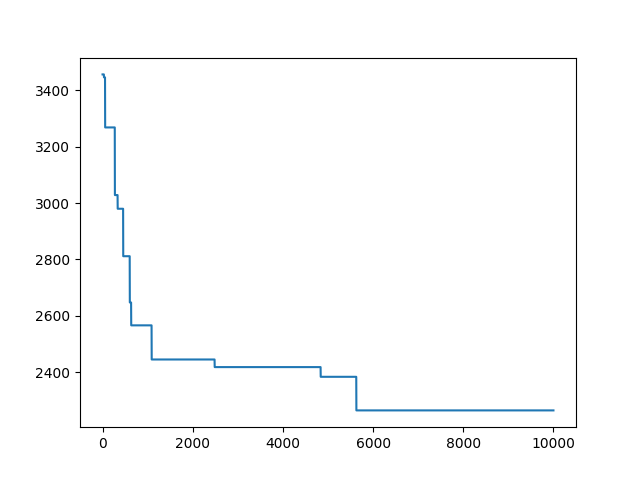

np.float64(2263.972556917865)

In [24]:
T0 = 1
sigma = 0.01
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

-> Sigma is too large

Initial loss: 3456.4013309558472
Iteration 1  - Temperature: 0.9999 Loss 3456.4013309558472
Iteration 2  - Temperature: 0.9998 Loss 3355.2074082821855
Iteration 3  - Temperature: 0.9997 Loss 3355.2074082821855
Iteration 4  - Temperature: 0.9996 Loss 3351.387276464385
Iteration 5  - Temperature: 0.9995 Loss 3351.387276464385
Iteration 6  - Temperature: 0.9994 Loss 3351.387276464385
Iteration 7  - Temperature: 0.9993 Loss 3351.387276464385
Iteration 8  - Temperature: 0.9992 Loss 2959.8412026131004
Iteration 9  - Temperature: 0.9991 Loss 2959.8412026131004
Iteration 10  - Temperature: 0.999 Loss 2959.8412026131004
Iteration 11  - Temperature: 0.9989 Loss 2959.8412026131004
Iteration 12  - Temperature: 0.9988 Loss 2699.1008887992953
Iteration 13  - Temperature: 0.9987 Loss 2699.1008887992953
Iteration 14  - Temperature: 0.9986 Loss 2699.1008887992953
Iteration 15  - Temperature: 0.9985 Loss 2528.233668020351
Iteration 16  - Temperature: 0.9984 Loss 2528.233668020351
Iteration 17  - Tempera

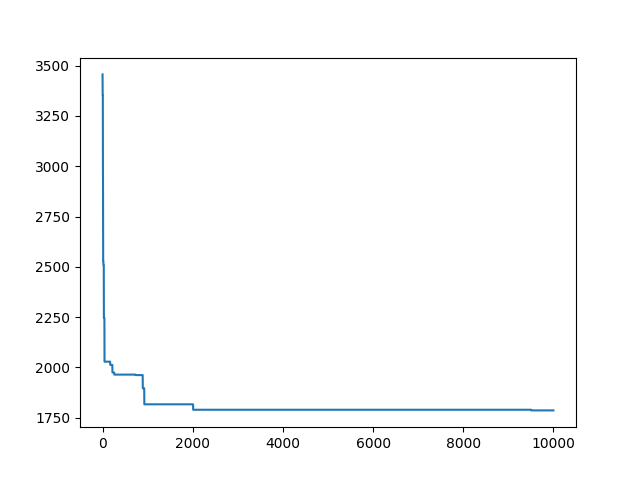

np.float64(1786.5866675660884)

In [25]:
T0 = 1
sigma = 0.001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

-> Sigma is too large

Initial loss: 3456.4013309558472
Iteration 1  - Temperature: 0.9999 Loss 3372.6503597727983
Iteration 2  - Temperature: 0.9998 Loss 3362.004702923473
Iteration 3  - Temperature: 0.9997 Loss 3297.0452723465824
Iteration 4  - Temperature: 0.9996 Loss 3297.0452723465824
Iteration 5  - Temperature: 0.9995 Loss 3297.0452723465824
Iteration 6  - Temperature: 0.9994 Loss 3163.3856111668338
Iteration 7  - Temperature: 0.9993 Loss 3163.3856111668338
Iteration 8  - Temperature: 0.9992 Loss 3163.3856111668338
Iteration 9  - Temperature: 0.9991 Loss 3163.3856111668338
Iteration 10  - Temperature: 0.999 Loss 3164.763059234382
Iteration 11  - Temperature: 0.9989 Loss 3164.763059234382
Iteration 12  - Temperature: 0.9988 Loss 3073.9275771536622
Iteration 13  - Temperature: 0.9987 Loss 3021.603582062207
Iteration 14  - Temperature: 0.9986 Loss 3021.603582062207
Iteration 15  - Temperature: 0.9985 Loss 3021.603582062207
Iteration 16  - Temperature: 0.9984 Loss 2941.020063295591
Iteration 17  - Temperat

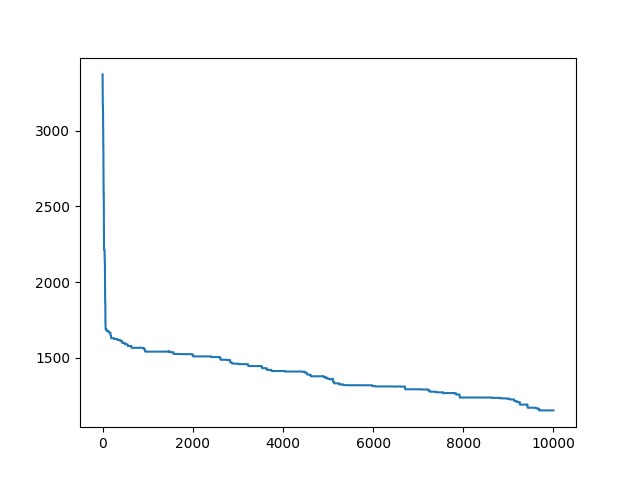

np.float64(1152.943060016535)

In [27]:
T0 = 1
sigma = 0.0001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

Initial loss: 3456.4013309558472
Iteration 1  - Temperature: 0.9999 Loss 3439.43832450951
Iteration 2  - Temperature: 0.9998 Loss 3439.43832450951
Iteration 3  - Temperature: 0.9997 Loss 3439.43832450951
Iteration 4  - Temperature: 0.9996 Loss 3396.445699809907
Iteration 5  - Temperature: 0.9995 Loss 3386.280119796388
Iteration 6  - Temperature: 0.9994 Loss 3311.527866253044
Iteration 7  - Temperature: 0.9993 Loss 3311.527866253044
Iteration 8  - Temperature: 0.9992 Loss 3270.6354375046426
Iteration 9  - Temperature: 0.9991 Loss 3240.0047668244342
Iteration 10  - Temperature: 0.999 Loss 3240.0047668244342
Iteration 11  - Temperature: 0.9989 Loss 3178.8067822992757
Iteration 12  - Temperature: 0.9988 Loss 3178.8067822992757
Iteration 13  - Temperature: 0.9987 Loss 3178.823547409912
Iteration 14  - Temperature: 0.9986 Loss 3166.271323747046
Iteration 15  - Temperature: 0.9985 Loss 3142.621461619288
Iteration 16  - Temperature: 0.9984 Loss 3142.621461619288
Iteration 17  - Temperature: 0.

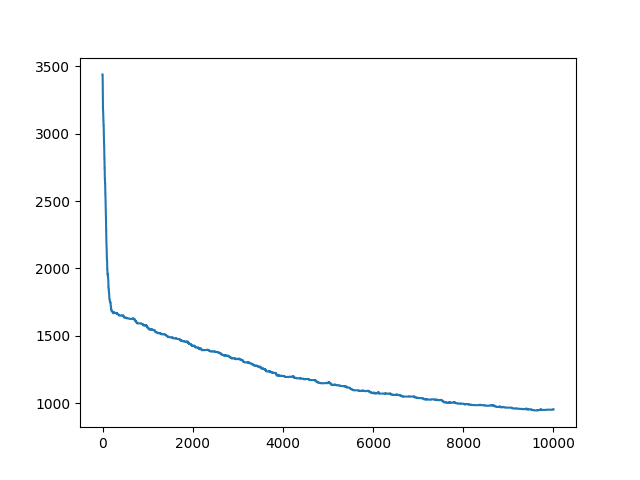

np.float64(955.1671702185814)

In [28]:
T0 = 1
sigma = 0.00001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

-> we can test sigma from 1e-3 to 1e-10

### Test to find the sigma range

Initial loss: 3456.4013309558472
Iteration 1  - Temperature: 0.09999000000000001 Loss 3416.0675553599153
Iteration 2  - Temperature: 0.09998000000000001 Loss 3414.350467116131
Iteration 3  - Temperature: 0.09997 Loss 3414.350467116131
Iteration 4  - Temperature: 0.09996000000000001 Loss 3414.350467116131
Iteration 5  - Temperature: 0.09995000000000001 Loss 3411.120226006877
Iteration 6  - Temperature: 0.09994 Loss 3347.274352262447
Iteration 7  - Temperature: 0.09993 Loss 3347.274352262447
Iteration 8  - Temperature: 0.09992000000000001 Loss 3263.2555984587343
Iteration 9  - Temperature: 0.09991 Loss 3256.808537261211
Iteration 10  - Temperature: 0.0999 Loss 3256.808537261211
Iteration 11  - Temperature: 0.09989 Loss 3256.808537261211
Iteration 12  - Temperature: 0.09988000000000001 Loss 3256.808537261211
Iteration 13  - Temperature: 0.09987000000000001 Loss 3180.434148385565
Iteration 14  - Temperature: 0.09986 Loss 3180.434148385565
Iteration 15  - Temperature: 0.09985000000000001 Lo

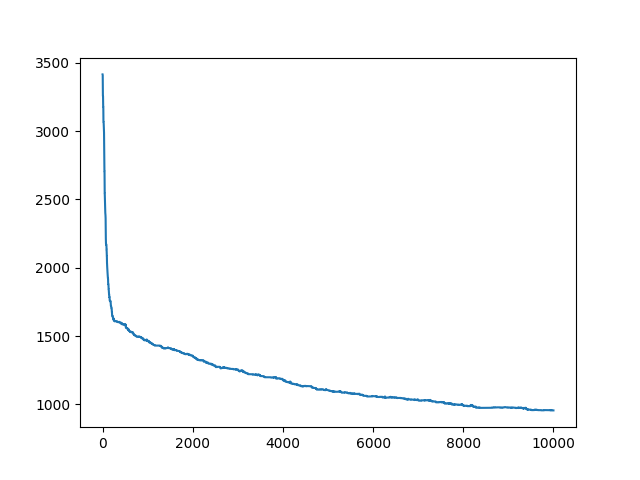

np.float64(955.1759943196291)

In [31]:
T0 = 0.1
sigma = 0.00001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

Initial loss: 3456.4013309558472
Iteration 1  - Temperature: 4.9995 Loss 3456.4013309558472
Iteration 2  - Temperature: 4.9990000000000006 Loss 3443.528846012679
Iteration 3  - Temperature: 4.9985 Loss 3424.635689172432
Iteration 4  - Temperature: 4.998 Loss 3409.8678730237484
Iteration 5  - Temperature: 4.9975000000000005 Loss 3409.8678730237484
Iteration 6  - Temperature: 4.997 Loss 3393.670279488761
Iteration 7  - Temperature: 4.9965 Loss 3340.565247632005
Iteration 8  - Temperature: 4.9959999999999996 Loss 3340.565247632005
Iteration 9  - Temperature: 4.9955 Loss 3324.5802440871043
Iteration 10  - Temperature: 4.995 Loss 3324.5802440871043
Iteration 11  - Temperature: 4.9945 Loss 3308.7870829252056
Iteration 12  - Temperature: 4.994 Loss 3308.7870829252056
Iteration 13  - Temperature: 4.9935 Loss 3308.7870829252056
Iteration 14  - Temperature: 4.993 Loss 3286.647650878866
Iteration 15  - Temperature: 4.992500000000001 Loss 3286.647650878866
Iteration 16  - Temperature: 4.992 Loss 3

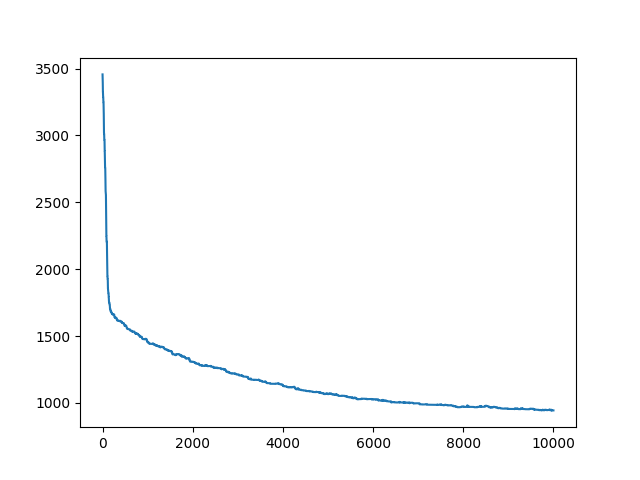

np.float64(944.2957311037702)

In [33]:
T0 = 5
sigma = 0.00001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

Initial loss: 3456.4013309558472
Iteration 1  - Temperature: 9.999 Loss 3456.403625223255
Iteration 2  - Temperature: 9.998000000000001 Loss 3456.403625223255
Iteration 3  - Temperature: 9.997 Loss 3456.403625223255
Iteration 4  - Temperature: 9.996 Loss 3456.403625223255
Iteration 5  - Temperature: 9.995000000000001 Loss 3427.4583634627993
Iteration 6  - Temperature: 9.994 Loss 3427.4583634627993
Iteration 7  - Temperature: 9.993 Loss 3381.976094499196
Iteration 8  - Temperature: 9.991999999999999 Loss 3347.846122903044
Iteration 9  - Temperature: 9.991 Loss 3347.846122903044
Iteration 10  - Temperature: 9.99 Loss 3347.846122903044
Iteration 11  - Temperature: 9.989 Loss 3313.9149077634484
Iteration 12  - Temperature: 9.988 Loss 3313.9149077634484
Iteration 13  - Temperature: 9.987 Loss 3296.488337027255
Iteration 14  - Temperature: 9.986 Loss 3296.488337027255
Iteration 15  - Temperature: 9.985000000000001 Loss 3296.488337027255
Iteration 16  - Temperature: 9.984 Loss 3296.8984468650

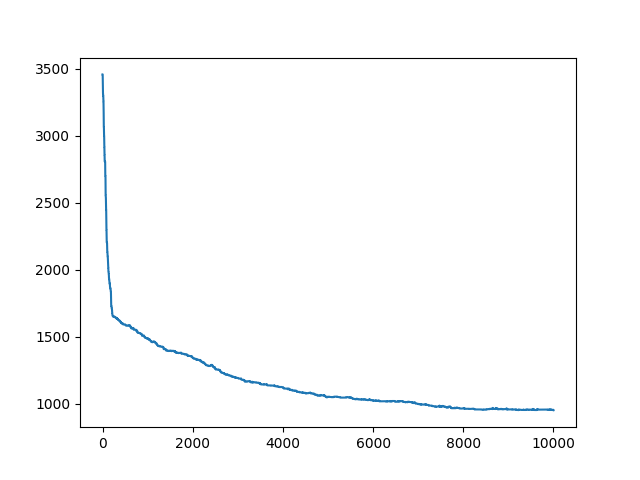

np.float64(951.9617044576466)

In [30]:
T0 = 10
sigma = 0.00001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

-> there is no big diffrence. so we will test T0 from 0.1 to 10

### run of 64 combination of T0 and Sigma in parallel

In [ ]:
# 64 combination of T0 (0.1 to 10) and Sigma (1e-10 to 1e-3)



Optimal hyper-parameter values are :<br>
T0 = <br>
sigma = <br>

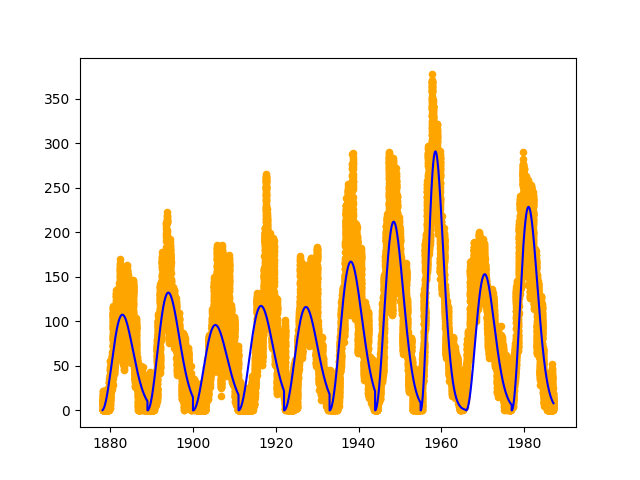

In [81]:
# Check the final state of the tuning process

plt.figure()
plt.scatter(time_points, data_points, color='orange', s=20)
plt.plot(time_points, model(time_points, outSA[-1]), color='blue')
plt.show(block=False)

## Final optimization

In [ ]:
#initial condition
x0_from_tuning = outSA[-1]

# Number of chains for final optimization
n_chains = 10
# Perturb the initial condition for each chain
x0noisy = np.abs(x0_from_tuning + np.random.normal(0, np.tile(np.array([0.01, 1, 0.0005]), 3), (n_chains, 9))) # abs avoids negative numbers

T0 = 0.2
sigma = 1e-5

n_iter = 1500
burn_in = 1000

In [ ]:
results = np.empty((int(n_chains*(n_iter - burn_in)),9))

for ix in range(n_chains):

    opt = simulated_annealing_ optim(x0noisy[ix], T0, sigma, mse, burn_in = burn_in, n_iter = n_iter)
    start_idx = ix * opt.shape[0]
    end_idx = start_idx + opt.shape[0]
    # write the 'opt' output directly into the allocated array
    results[start_idx : end_idx, :] = opt
    

In [ ]:
results

In [ ]:
n_params = 9

In [ ]:
center_of_mass = np.zeros(n_params)
for ix in range(n_params):
    counts, bin_edges = np.histogram(chain[:,ix], bins=20)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Calculate the center of mass
   # Weights are the counts of each bin
    center_of_mass[ix] = np.sum(counts * bin_centers) / np.sum(counts)

In [ ]:
plt.figure()
plt.scatter(time_points, data_points, color ='orange', s=10)
plt.plot(time_points, model(time_points, *params), color='blue')
plt.show(block=False)

In [ ]:
center_of_mass

In [ ]:
#correct manually for the first time-point
center_of_mass[0] = 0

In [ ]:
plt.figure()
plt.scatter(time_points, data_points, color ='orange', s=10)
plt.plot(time_points, model(time_points, *params), color='blue')
plt.show(block=False)